<a href="https://colab.research.google.com/github/Ankandas14/Computer_Vision_DL/blob/main/CFAIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
!pip install torchinfo
!pip install torchmetrics
from torchinfo import summary
from torchmetrics import Accuracy


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# If CUDA is available, print the CUDA device name
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla T4


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Here are the classes in the dataset:

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck

Data Preparation and Augmentation

In [ ]:
# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [ ]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

100%|██████████| 170M/170M [00:08<00:00, 19.9MB/s]


In [ ]:
class_names = train_data.classes

class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

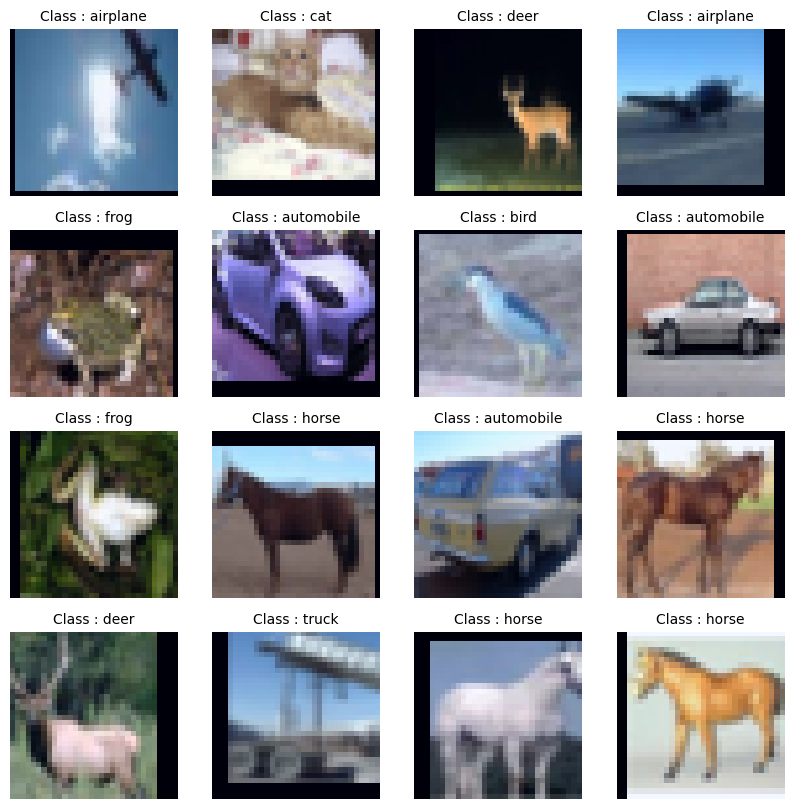

In [ ]:
## look into the data we've downloaded
import random

rand_idx = random.sample(range(len(train_data)),k=16)

plt.figure(figsize=(10,10))

for i , idx in enumerate(rand_idx):

  img , label = train_data[idx]

  #the image tensor's range is not between 0 and 1,so we have to temporarily scale the tensor values into range 0 and 1 to prevent error.
  img = (img - img.min()) / (img.max() - img.min())

  img_class = class_names[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)

Load the Data

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 800

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)